## 10. 나를 찾아줘 - Class Activation Map 만들기

### [ 목  차 ]
1. 자료 불러오기
2. CAM 구현하기
3. Grad-CAM 구현하기
4. 바운딩 박스 구하기
5. IoU 구하기
6. 결 론     

[ 회 고 ]

###1. 자료 불러오기

In [ ]:
# 라이브러리 가져오기
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
import PIL
from PIL import Image

print('슝=3')

슝=3


In [ ]:
# GPU 연결 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# GPU Spec
!nvidia-smi

Wed Jul 20 03:30:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# 데이터셋 stanford_dogs
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteDP68BP/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteDP68BP/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝=3


In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [ ]:
# 데이터셋 클래스 개수
NUM_CLASSES = ds_info.features["label"].num_classes
NUM_CLASSES 

120

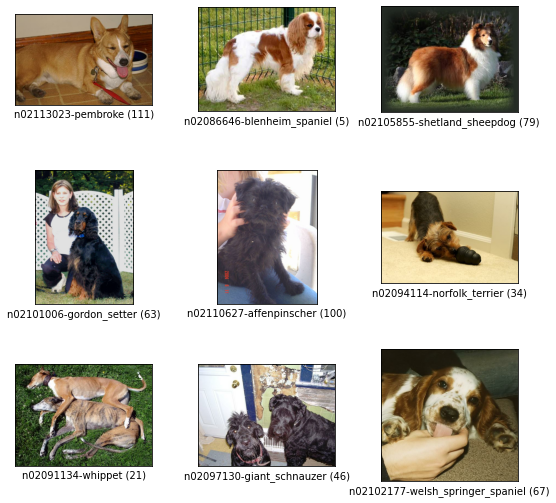

In [ ]:
# 각 이미지 클래스와 인덱스 확인
fig = tfds.show_examples(ds_train, ds_info)

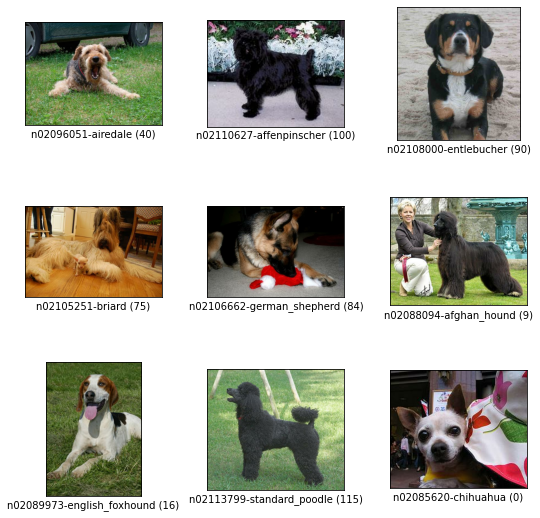

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

#### 이미지 전처리

In [ ]:
BATCH_SIZE = 16

# 학습 데이터와 검증 데이터에 normalizing 과 resizing 적용
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

In [ ]:
# normalize, resize, shuffle 적용
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test_norm = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


### 2. CAM 구현하기

In [ ]:
# ResNet50 기반 CAM 모델

def create_cam_model():
    base_model = keras.applications.resnet50.ResNet50(
        include_top=False,    # Imagenet 분류기  fully connected layer 제거
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',      # GAP를 적용  
    )
    x = base_model.output
    preds = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

    cam_model = keras.Model(inputs=base_model.input, outputs=preds)
    return cam_model

In [ ]:
# 모델 요약
cam_model = create_cam_model()
cam_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
# 모델 학습 함수

def compile_and_fit(cam_model, epochs=2, batch_size=16):
    cam_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy'],
    )

    history_cam_model = cam_model.fit(
        ds_train_norm,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test_norm,
        verbose=1,
        use_multiprocessing=True,
    )

    return history_cam_model

In [ ]:
# 모델 학습

EPOCHS = 30

history_cam_model = compile_and_fit(cam_model, EPOCHS, BATCH_SIZE)

Epoch 1/30
750/750 [==============================] - 178s 213ms/step - loss: 2.2289 - accuracy: 0.4423 - val_loss: 3.5517 - val_accuracy: 0.1876
Epoch 2/30
750/750 [==============================] - 158s 210ms/step - loss: 0.6675 - accuracy: 0.8232 - val_loss: 1.0956 - val_accuracy: 0.6723
Epoch 3/30
750/750 [==============================] - 157s 210ms/step - loss: 0.1917 - accuracy: 0.9653 - val_loss: 0.9295 - val_accuracy: 0.7250
Epoch 4/30
750/750 [==============================] - 157s 210ms/step - loss: 0.0494 - accuracy: 0.9966 - val_loss: 0.8985 - val_accuracy: 0.7382
Epoch 5/30
750/750 [==============================] - 157s 210ms/step - loss: 0.0203 - accuracy: 0.9997 - val_loss: 0.9030 - val_accuracy: 0.7396
Epoch 6/30
750/750 [==============================] - 157s 210ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.9266 - val_accuracy: 0.7401
Epoch 7/30
750/750 [==============================] - 157s 209ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.9179 -

In [ ]:
# 학습 결과 시각화 함수
def draw_history(history):
    plt.subplots(figsize=(12,4))

    # CAM Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title('CAM Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # CAM Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title('CAM Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.show()

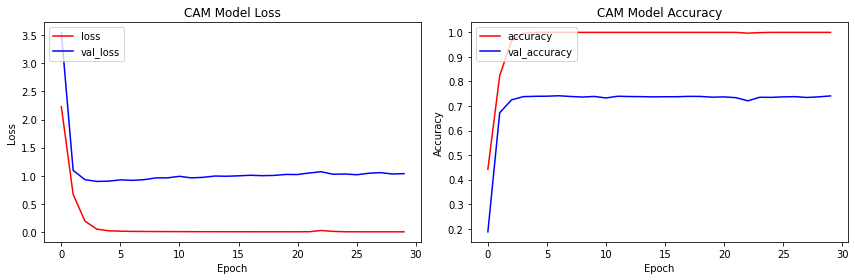

In [ ]:
# 시각화
draw_history(history_cam_model)

In [ ]:
# 학습한 모델 저장
CAM_MODEL_PATH = f'/content/drive/MyDrive/going_deeper/cam_model/my_cam_model_{EPOCHS}.h5'

In [ ]:
cam_model.save(CAM_MODEL_PATH)
print("Save CAM Model")

Save CAM Model


In [ ]:
# 학습한 모델 불러오기
cam_model = tf.keras.models.load_model(CAM_MODEL_PATH)
print("Load CAM Model")

Load CAM Model


In [ ]:
# CAM 반환 함수 만들기

def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]  # 마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [ ]:
# 데이터셋에서 한 장 뽑아서 이미지 확인하는 함수
def get_one(ds):
    ds = ds.shuffle(buffer_size=20000)
    
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    # print(label)
    return sample_data[0]

print('슝=3')

슝=3


In [ ]:
# CAM 이미지와 원본 이미지 합치는 함수
def get_cam_image_3channel(item, cam_image, alpha=0.7):
    origin_image = item['image'].astype(np.uint8)

    # - 문제: cam_image 픽셀 값이 음수일 경우 255 를 곱해봤자 음수가 되므로 cv2.addWeighted() 가 제대로 진행되지 않는다. => 음수인 부분만 얼룩진 것처럼 됨
    # - 해결: ReLU 처리(음수를 0으로 만듦)를 통해 완전한 0~255 컬러 표현이 가능해짐 => cv2.addWeighted() 를 했을 때 부드럽게 블렌딩됨!
    cam_image_3channel = np.stack(np.maximum([cam_image*255]*3,0), axis=-1).astype(np.uint8)

    # 기존 lms 코드에 있던 visualize_cam_on_image(src1, src2, alpha=0.5)과 동일한 기능
    blended_image = cv2.addWeighted(cam_image_3channel, alpha, origin_image, 1.0-alpha, 0.0)
    return blended_image

In [ ]:
# 테스트 이미지, CAM 이미지, 테스트 이미지 + CAM 확인 함수
def draw_imgs(item, cam_image, blended_image, filename='CAM_Iamge.png'):
    plt.figure(figsize=(12,4))

    # 데이터셋에서 한 장 뽑아서 이미지 확인
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(item['image'])

    # 얻어낸 CAM 이미지 확인
    plt.subplot(132)
    plt.axis('off')
    plt.imshow(cam_image)

    # CAM 이미지와 원본 이미지 합치기
    plt.subplot(133)
    plt.axis('off')
    plt.imshow(blended_image)

    plt.tight_layout()
    plt.show()

In [ ]:
# CAM 과 Grad CAM 비교를 위해 item 은 같은 이미지를 사용할 예정
item = get_one(ds_test)  # 데이터셋에서 이미지 한 장 뽑기

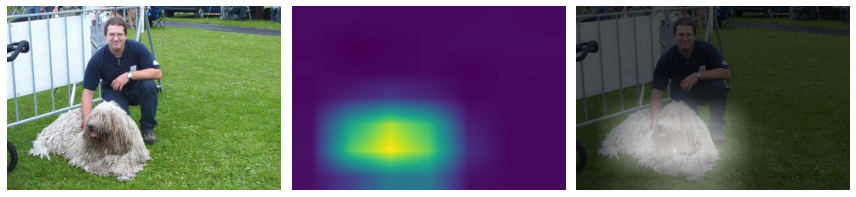

In [ ]:
# CAM 결과 시각화
cam_image_1 = generate_cam(cam_model, item)  # CAM 이미지 얻기
blended_image_1 = get_cam_image_3channel(item, cam_image_1)  # CAM 이미지와 원본 이미지 합치기

draw_imgs(item, cam_image_1, blended_image_1, filename='CAM_Iamge_1.png')

### 3. Grad-CAM 구현하기

In [ ]:
# Grad-CAM 반환 함수
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

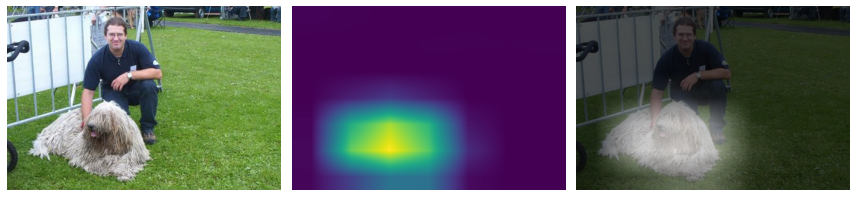

In [ ]:
# Grad-CAM 결과 시각화
grad_cam_image_1 = generate_grad_cam(cam_model, 'conv5_block3_out', item)  # Grad-CAM 이미지 얻기
blended_image_2 = get_cam_image_3channel(item, grad_cam_image_1)  # CAM 이미지와 원본 이미지 합치기

draw_imgs(item, grad_cam_image_1, blended_image_2, filename='Grad_CAM_Iamge_1.png')

#### Grad-CAM 전체 레이어 CAM 이미지 확인

In [ ]:
# CAM model 레이어 이름 목록
CONV_NAMES = [
    'conv2_block1_out',
    'conv2_block2_out',
    'conv2_block3_out',
    'conv3_block1_out',
    'conv3_block2_out',
    'conv3_block3_out',
    'conv3_block4_out',
    'conv4_block1_out',
    'conv4_block2_out',
    'conv4_block3_out',
    'conv4_block4_out',
    'conv4_block5_out',
    'conv4_block6_out',
    'conv5_block1_out',
    'conv5_block2_out',
    'conv5_block3_out',
]

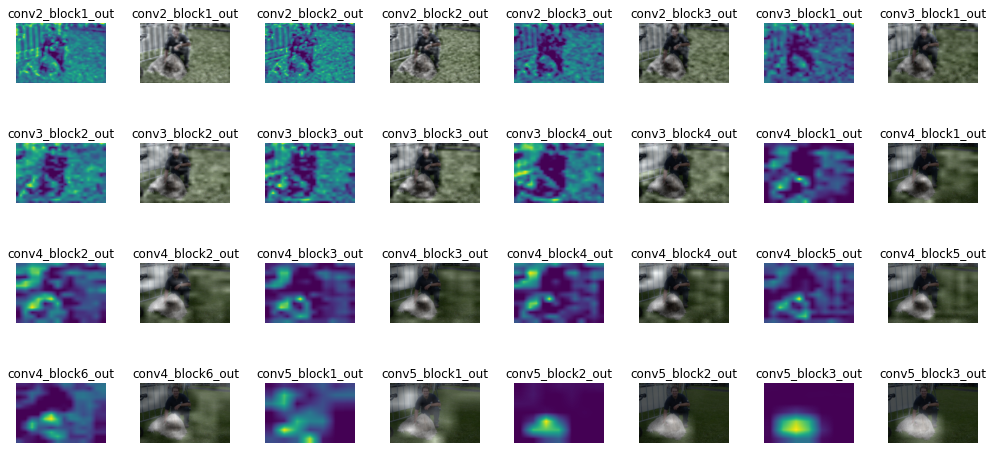

In [ ]:
grad_cam_images = []
blended_images = []

len_ = len(CONV_NAMES)  # 16
cols = 8
rows = len_//cols * 2  # 두 개(feature map, 원본 + CAM)씩 보여줘야 하므로 *2를 함

plt.figure(figsize=(14,7))
j = 1
for i in range(len(CONV_NAMES)):
    grad_cam_image = generate_grad_cam(cam_model, CONV_NAMES[i], item)
    blended_image = get_cam_image_3channel(item, grad_cam_image)

    grad_cam_images.append(grad_cam_image)
    blended_images.append(blended_image)

    # draw
    plt.subplot(rows,cols,j)
    plt.axis('off')
    plt.title(CONV_NAMES[i])
    plt.imshow(grad_cam_image)
    j += 1

    plt.subplot(rows,cols,j)
    plt.axis('off')
    plt.title(CONV_NAMES[i])
    plt.imshow(blended_image)
    j += 1

plt.tight_layout()
plt.show()

### 4. 바운딩 박스 구하기

In [ ]:
# 바운딩 박스 생성 함수
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


In [ ]:
# CAM 바운딩 박스 그리기
rect_1 = get_bbox(cam_image_1)
rect_1

array([[ 34, 294],
       [ 34, 120],
       [318, 120],
       [318, 294]])

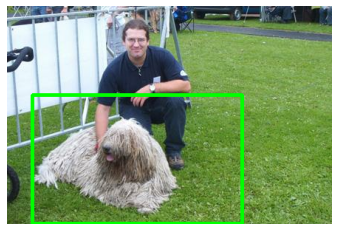

In [ ]:
image_1 = copy.deepcopy(item['image'])
image_1 = cv2.drawContours(image_1, [rect_1], 0, (0,255,0), 3)
plt.axis('off')
plt.imshow(image_1)
plt.show()

In [ ]:
# Grad-CAM 바운딩 박스 그리기
rect_2 = get_bbox(grad_cam_image_1)
rect_2

array([[ 34, 293],
       [ 34, 117],
       [319, 117],
       [319, 293]])

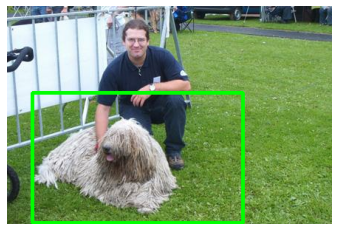

In [ ]:
image_2 = copy.deepcopy(item['image'])
image_2 = cv2.drawContours(image_2, [rect_2], 0, (0,255,0), 3)
plt.axis('off')
plt.imshow(image_2)
plt.show()

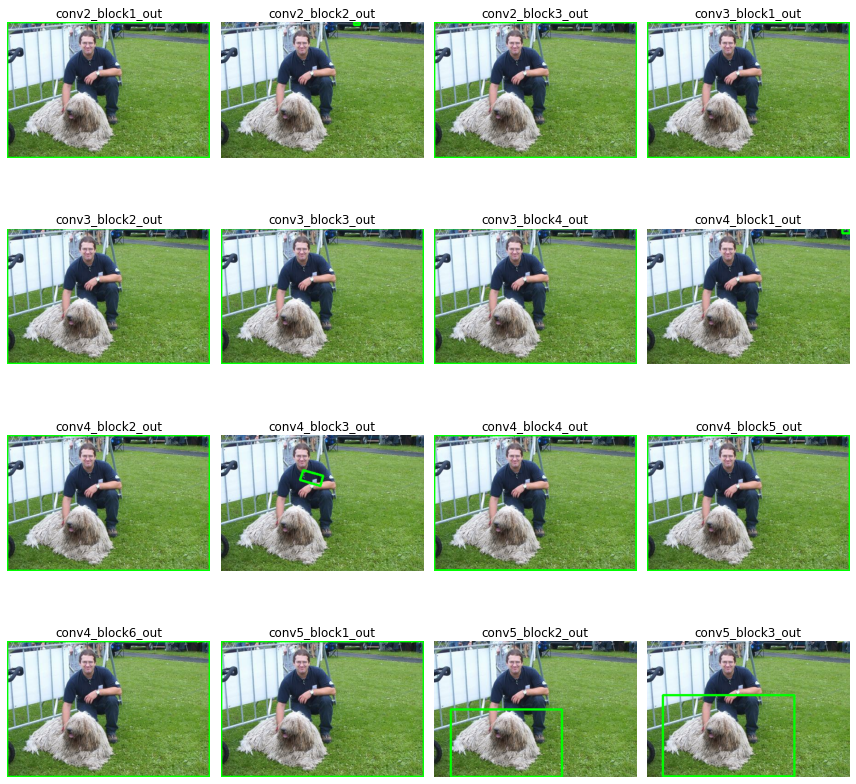

In [ ]:
# Grad-CAM 전체 레이어 바운딩 박스 그리기
grad_cam_rects = []

len_ = len(CONV_NAMES)
cols = 4
rows = math.ceil(len_/cols)

plt.figure(figsize=(12,12))
for i, (grad_cam_image, conv_name) in enumerate(zip(grad_cam_images, CONV_NAMES)):
    rect = get_bbox(grad_cam_image)
    grad_cam_rects.append(rect)

    image = copy.deepcopy(item['image'])
    image = cv2.drawContours(image, [rect], 0, (0,255,0), 3)

    # draw
    plt.subplot(rows,cols,i+1)
    plt.axis('off')
    plt.title(conv_name)
    plt.imshow(image)

plt.tight_layout()
plt.show()

### 5. IoU 구하기

In [ ]:
# rect를 minmax bbox 형태로 치환하는 함수
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  # bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  # bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),  # bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]),  # bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


In [ ]:
# IoU 계산 함수
def get_iou(pred_bbox, gt_bbox):
    y_min = max(pred_bbox[0], gt_bbox[0])
    x_min= max(pred_bbox[1], gt_bbox[1])
    y_max = min(pred_bbox[2], gt_bbox[2])
    x_max = min(pred_bbox[3], gt_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    pred_bboxArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    gt_bboxArea = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    iou = interArea / float(pred_bboxArea + gt_bboxArea - interArea)

    return iou

print('슝=3')

슝=3


In [ ]:
# CAM IoU 구하기
pred_bbox_1 = rect_to_minmax(rect_1, item['image'])
pred_bbox_1

[0.4067796610169492,
 0.07727272727272727,
 0.9966101694915255,
 0.7227272727272728]

In [ ]:
item['objects']['bbox']

array([[0.5084746 , 0.07272727, 0.95932204, 0.5318182 ]], dtype=float32)

In [ ]:
cam_iou = round(get_iou(pred_bbox_1, item['objects']['bbox'][0]),4)
cam_iou

0.5354

In [ ]:
# Grad-CAM IoU 구하기
pred_bbox_2 = rect_to_minmax(rect_2, item['image'])
pred_bbox_2

[0.39661016949152544, 0.07727272727272727, 0.9932203389830508, 0.725]

In [ ]:
item['objects']['bbox']

array([[0.5084746 , 0.07272727, 0.95932204, 0.5318182 ]], dtype=float32)

In [ ]:
get_iou(pred_bbox_2, item['objects']['bbox'][0])

0.5275056765374859

In [ ]:
# Grad-CAM 전체 레이어 IoU 확인
grad_cam_iou_dict = {}
for i, (rect, conv_name) in enumerate(zip(grad_cam_rects, CONV_NAMES)):
    pred_bbox = rect_to_minmax(rect, item['image'])
    iou = get_iou(pred_bbox, item['objects']['bbox'][0])
    grad_cam_iou_dict[conv_name] = round(iou,4)
    print(f'* {conv_name}의 IoU 계산 결과: {grad_cam_iou_dict[conv_name]}')

* conv2_block1_out의 IoU 계산 결과: 0.2082
* conv2_block2_out의 IoU 계산 결과: 0.0
* conv2_block3_out의 IoU 계산 결과: 0.2082
* conv3_block1_out의 IoU 계산 결과: 0.2082
* conv3_block2_out의 IoU 계산 결과: 0.2082
* conv3_block3_out의 IoU 계산 결과: 0.2082
* conv3_block4_out의 IoU 계산 결과: 0.2082
* conv4_block1_out의 IoU 계산 결과: 0.0
* conv4_block2_out의 IoU 계산 결과: 0.2082
* conv4_block3_out의 IoU 계산 결과: 0.0
* conv4_block4_out의 IoU 계산 결과: 0.2093
* conv4_block5_out의 IoU 계산 결과: 0.2082
* conv4_block6_out의 IoU 계산 결과: 0.2082
* conv5_block1_out의 IoU 계산 결과: 0.2082
* conv5_block2_out의 IoU 계산 결과: 0.7373
* conv5_block3_out의 IoU 계산 결과: 0.5275


### 6. 결론 및 회고

*   사람과 개가 함께 있는 이미지에서 CAM 방식과 Grad-CAM 방식 모두 개 영역을 잘 활성화 시키고 있음을 확인함
*   바운딩박스와 IoU 계산을 통한 object localization 성능과 관련하여 CAM 방식은 마지막 레이어를 통한 localization 만 수행 가능하며 IoU 0.5354를 기록하였며, Grad-CAM 방식은 모든 레이어에 대해 localization 계산이 가능하여 conv5_block2_out의 IoU 0.7373으로 성능이 더 우수함
* Grad-CAM 방식에서 항상 가장 마지막 레이어의 성능이 가장 우수한 것은 아님을 확인함
* weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이 무엇인지 이해할 수 있게 되었음
       
       
< reference >
* (paper) Learning Deep Features for Discriminative Localization
* (paper) Grad-CAM: Visual Explations from Deep Networks via Gradient-based Localization
* https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/



